In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with quantum linear non-Gaussian acyclic model (qLiNGAM) for causal discovery

In this notebook, we show how to derive causal relationships between different variables and heart disease observed in patients using a quantum model for causal discovery.

Quantum machine learning algorithms, namely quantum kernel approaches, map the data from a lower-dimensional space into a large quantum Hilbert space to reveal insights that are hidden in its complex local structure to obtain an improved solution. Here we implement a quantum algorithm for causal discovery, enhancing the linear non-Gaussian acyclic model with a quantum kernel (qLiNGAM). Specifically, we show how the quantum kernel is employed to compute the independence measure that is required to predict the causal order of the data set. Our implementation closely follows the qLiNGAM approach described in Kawaguchi 2021.<sup>1</sup> The results of this study suggest that qLiNGAM may be able to discover medical knowledge even if the amount of data is small and a classical causal approach fails.

#### Import packages

First, we load some necessary modules to carry out this investigation.

In [2]:
# Standard packages 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# LiNGAM
from lingam import DirectLiNGAM
from src.qlingam import qDirectLiNGAM

# Qiskit
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import Parameter, QuantumRegister
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_aer.primitives import Sampler

import warnings
warnings.simplefilter('ignore')

# Initialize
seed = 98765
algorithm_globals.random_seed = seed

# Parameters
run_options = {
    "shots" : 1024
}

fidelity = ComputeUncompute(sampler=Sampler(run_options=run_options)) #aer_simulator

Python function to plot a causal graph:

In [3]:
import networkx as nx

def plot_dag_nx(adjacency_matrix, columns):
    rows, cols = np.where(adjacency_matrix != 0)
    edges = [(columns[i], columns[j]) for i,j in zip(cols.tolist(), rows.tolist())]
    G = nx.DiGraph(edges)
    for i,j in zip(cols.tolist(), rows.tolist()):
        G[columns[i]][columns[j]]['weight'] = f'{adjacency_matrix[j][i]:.2f}'

    pos = nx.spring_layout(G)
    weight_labels = nx.get_edge_attributes(G,'weight')
    nx.draw(G, pos, node_size=4000, with_labels=True, node_color='orange', font_size=16)
    output = nx.draw_networkx_edge_labels(G,pos,edge_labels=weight_labels, font_size=14)

### Data preparation

#### Load the data

We use the UCI Heart Disease Data Set<sup>2</sup> to demonstrate the potential effectiveness of the quantum algorithm. With this data set, we aim to find causal relationships between variables and heart disease in patients.<sup>1</sup> To demonstrate the qLiNGAM algorithm, we select only 3 of the 14 variables, namely:
- **`age`**: age of the patient.
- **`cp`**: type of chest pain rated from `0` up to `3`.
- **`exang`**: presence or absence of exercise-induced angina.

The correct causal relationship is **`exang`** influencing **`cp`**, while **`age`** is independent of other variables.<sup>1</sup> We will conduct an experiment using 70 data points drawn randomly.



In [4]:
random_state = seed
n = 70
path_to_data = 'data/heart_disease_dataset_UCI.csv'
columns = ["age", "cp", "exang"]

df = pd.read_csv(path_to_data)
X = StandardScaler().fit_transform(df[columns].sample(n=n, random_state=random_state).reset_index(drop=True))

df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

### Theoretical foundation of qLiNGAM

To apply qLiNGAM for causal discovery, we assume that a data set has the following properties:
- Data $x_i$, $i\in \{ 1,...,m \}$ can be arranged in a causal order $k(i)$ such that no later variable causes any earlier variable. The causal order can be graphically represented by a directed acyclic graph (DAG), and the causal order can be generated in a recursive manner.
- We assume that the relationship between variables is linear and that each observed variable $x_i$ has zero mean. Then, causal relations can be described by the following equation:
$$
x_i=\sum_{k(j)<k(i)}b_{ij}x_j+e_i.
$$
where $e_i$ is an external influence. This can be rewritten in matrix form as
$$
\textbf{x}=\textbf{Bx}+\textbf{e}
$$
where $\textbf{x}$ is a $p$-dimensional random vector, and $\textbf{B}=\{ b_{ij} \}$ represents the connection strengths of the variables.
- $e_i$ are continuous random variables having non-Gaussian distributions with zero means and nonzero variance. Furthermore, $e_i$ are independent of each other so that $p(e_1,...,e_m)=\prod_ip_i(e_i)$.

Note that $\textbf{B}$ can be permuted to be strictly lower triangular due to the acyclicity assumption, and the goal is to estimate $\textbf{B}$ by observing data $\textbf{x}$ only.

#### Independence measure

The calculation of $\textbf{B}$, the independence measure, is key to determining the causal order.
For the independence measure for LiNGAM, this quantity can be measured using a normalized cross-covariance operator (NOCCO).
Here, the fact that the Hilbert-Schmidt norm of NOCCO approaches zero can be used as a condition for a pair of random variables to be independent, and this independence measure can be defined as

$$
I^{NOCCO}(X,Y)=||V_{YX}||_{HS}^2,
$$

where $V_{YX}$ is NOCCO of $X$ and $Y$, and $||\cdot||_{HS}$ is the Hilbert-Schmidt norm.
For a given finite sample of data $(X_1,Y_1),...,(X_n,Y_n)$, the empirical independence measure,

$$
\hat{I}_n^{NOCCO}(X,Y)=Tr[R_YR_X],
$$

can be computed.

Here $R_Y=G_Y(G_Y+n\epsilon_nI_n)^{-1}$ and $R_X=G_X(G_X+n\epsilon_nI_n)^{-1}$.
$G_X$ and $G_Y$ are the centralized Gram matrices, and $\epsilon_n$ is the regularization constant.

#### Quantum kernel estimation

In qLiNGAM, the Gram matrix, with an element $K_{ij}=k(x_i,x_j)$, is expressed in terms of a quantum kernel to obtain

$$
K_{ij}=\left| \left\langle \Phi(x_j) | \Phi(x_j) \right\rangle \right|^2.
$$

Note that to prepare the quantum state $\Phi(x)$, a quantum gate $U(x)$ operates on the initial state $\left| 0 \right\rangle^n$:

$$
U(x)\left| 0 \right\rangle^n=\left| \Phi(x) \right\rangle.
$$

To construct $U(x)$ with a quantum circuit, an instantaneous quantum polynomial time (IQP) circuit can be used:

$$
U_{IQP}(x)=H^{\otimes n}V_D(x)H^{\otimes n}...V_1(x)H^{\otimes n},
$$

Here qLiNGAM will be used to find the causal relationships between the variables **`age`**, **`cp`**, and **`exang`**. In this tutorial, we demonstrate how the classical DirectLiNGAM algorithm is enhanced with quantum kernel estimation (QKE). In general, the kernel is used by the DirectLiNGAM algorithm to compute the independence measure between two variables. For more background on the DirectLiNGAM algorithm, refer to Shimizu et al. 2011.<sup>3</sup> Note that we use the instantaneous quantum polynomial circuit (IQP) for QKE.<sup>4</sup> The motivation behind this choice is that it is known to be difficult to estimate the output probability distribution of this kernel accurately using a classical computer.<sup>4</sup>   

The quantum kernel constructed using the IQP circuit can be expressed as:  

$$  
K_{ij} = \left| \left\langle 0^n \left| U^{\dagger}_{IQP}(x_j) U_{IQP}(x_i) \right| 0^n \right\rangle \right|^2,  
$$  

where  

$$  
U_{IQP}(x)=H^{\otimes n}V_D(x)H^{\otimes n}...V_1H^{\otimes n}.  
$$  

Note that $H^{\otimes n}$ is the Hadamard gate and $V_D(x)$ is constructed using the $U1$ gate and the controlled $U1$ ($CU1$) gate. They are defined as:  

$$ 
U1(\lambda) = 
\begin{bmatrix} 
1 & 0 \
0 & e^{i\lambda} 
\end{bmatrix} 
$$ 
    
and 
    
$$ 
CU1(\lambda) = 
\begin{bmatrix} 
1 & 0 & 0 & 0\\ 
0 & 1 & 0 & 0\\ 
0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & e^{i\lambda} 
\end{bmatrix}. 
$$ 

Here, $\lambda$ is the value of the data. Following the implementation of the original qLiNGAM paper, the data is first normalized to have zero mean and unit variance. Furthermore, the activation functions that are widely used in the neural networks are selected, namely the `tanh-shrink` function, defined as: 

$$ 
tanh-shrink(x) = x - tanh(x).
$$ 

Finally, the depths (or repetition) of the IQP circuit have been chosen to be 2, and the number of qubits employed is 5.

Now we define an IQP circuit used for this tutorial:

In [5]:
# IQP Circuit
# taken from https://qiskit.org/documentation/_modules/qiskit/circuit/library/iqp.html#IQP
def IQP_circuit(num_qubits, num_depths, interactions, name='q'):
    
    # Set coefficients
    lam = Parameter('λ')
    coeff_cp = lam
    coeff_p = lam
    
    # Make IQP Circuit
    qr = QuantumRegister(num_qubits, name=name)
    circuit = QuantumCircuit(qr)
    for _ in range(num_depths):
        circuit.h(range(num_qubits))
        circuit.barrier(qr)
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if interactions[i][j]:
                    circuit.cp(coeff_cp, i, j)
                    circuit.barrier(qr)
        for i in range(num_qubits):
            if interactions[i][i]:
                circuit.p(coeff_p, i)
        circuit.barrier(qr)
    circuit.h(range(num_qubits))
    circuit.barrier(qr)
    return circuit

# IQP interaction matrix
def iqp_interactions(num_qubits):
    interactions = np.zeros((num_qubits, num_qubits))
    for i in range(num_qubits):
        interactions[i, i] = 1
        if i < num_qubits - 1: # Only neighbor qubit
            interactions[i, i+1] = 1
            interactions[i+1, i] = 1
    return interactions

### Implementation of qLiNGAM
The code below implements qLINGAM. 

[2, 1, 0]


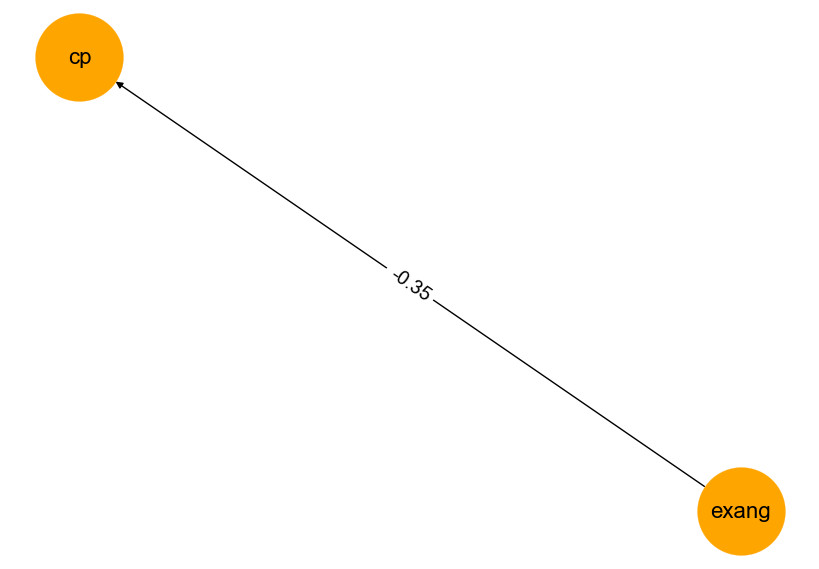

In [6]:
# IQP (parameters are from arxiv:2110.04485)
num_qubits = 5
num_depths = 2
feature_map = IQP_circuit(num_qubits, num_depths, iqp_interactions(num_qubits))
kernel_iqp = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

# Apply activation function to the data
tanh_shrink = lambda x: x - np.tanh(x)
x_tanh_shrink = np.vectorize(tanh_shrink)(X)

# IQP and normalized cross-covariance operator (NOCCO) for independence measure
epsilon = 1e-1

model_iqp_nocco = qDirectLiNGAM(measure='kernel')
model_iqp_nocco.fit(x_tanh_shrink, kernel=kernel_iqp, NOCCO=True, epsilon=epsilon)

print(model_iqp_nocco.causal_order_)
plot_dag_nx(model_iqp_nocco._estimate_adjacency_matrix(X).adjacency_matrix_, columns)

We see that the qLiNGAM algorithm correctly identifies the causal relationship for this particular data set.

### Implementation of classical DirectLiNGAM

Next, we will carry out the classical calculation using the DirectLiNGAM method presented in Shimizu et al. 2011.<sup>3</sup> Note that this classical approach uses a Gaussian kernel to describe the local structure of the data.

In the aforementioned system of equations describing causal relations ($\mathbf{x}=\mathbf{Bx}+\mathbf{e}$), $\mathbf{B}$ is the adjacency matrix representing the causal effect, and it can be permuted to be strictly lower triangular if causal ordering $k(i)$ of the variables is known. 

The goal of the algorithm is to determine $\mathbf{B}$. External influences $\mathbf{e}$ are continuous random variables having non-Gaussian distributions with zero means and nonzero variances. Finally, $e_i$, components of $\mathbf{e}$, are independent of each other so that there are no latent confounding variables.

In DirectLiNGAM, a kernel-based independence measure is used to evaluate pairwise independence between variables. More concretely, the following statistic is used to evaluate the independence between $x_j$ and its residuals $r_i^{(j)}=x_i-\frac{\text{cov}(x_i,x_j)}{\text{var}(x_j)}x_j$:

$$T_{kernel}(x_j;U)=\sum_{i\in U, i\ne j} \widehat{MI}_{kernel}(x_,r_i^{(j)}).$$

The kernel-based estimator of mutual information ($\widehat{MI}_{kernel}$) is defined as

$$\widehat{MI}_{kernel}(y_1,y_2) = -\frac{1}{2}\log \frac{\text{det}\mathcal{K_K}}{\text{det}\mathcal{D_K}},$$

where

$$\mathcal{K_K}=
        \begin{bmatrix} (K_1+\frac{n\mathcal{K}}{2}I)^2 & K_1K_2 \\ K_2K_1 & (K_2+\frac{n\mathcal{K}}{2}I)^2 
        \end{bmatrix}$$

$$\mathcal{D_K}=
        \begin{bmatrix} (K_1+\frac{n\mathcal{K}}{2}I)^2 & 0 \\ 0 & (K_2+\frac{n\mathcal{K}}{2}I)^2
        \end{bmatrix}.$$

Note that $K_1$ and $K_2$ are the Gaussian kernel values

$$K_1(y_1^{(i)},y_1^{(j)})=\text{exp}\left(-\frac{1}{2\sigma^2}|| y_1^{(i)}-y_1^{(j)} ||^2\right)$$

$$K_2(y_2^{(i)},y_2^{(j)})=\text{exp}\left(-\frac{1}{2\sigma^2}|| y_2^{(i)}-y_2^{(j)} ||^2\right).$$

The DirectLiNGAM proceeds in the following manner:

1. Initialize an ordered list $K:=\emptyset$ and $m:=1$ given a $p$-dimensional random vector $\mathbf{x}$, a set of variable subscripts $U=\{1,...,p\}$, and a $p\times n$ data matrix $\mathbf{X}$.

2. Repeat until $p-1$ subscripts are appended to $K$:

* Perform least squares regressions of $x_i$ on $x_j$ for all $i\in U-K (i\ne j)$ and compute the residual vectors $\mathbf{r}^{(j)}$ and the residual matrix $\mathbf{R}^{(j)}$ from the data matrix $\mathbf{X}$ for all $j\in U-K$. Find a variable $x_m$ that is most independent of its residuals:

$$x_m=\text{arg min}_{j\in U|K} T_{kernel}(x_j;U-K).$$

* Append $m$ to the end of $K$.
* Let $\mathbf{x}:=\mathbf{r}^{(m)}$, $\mathbf{X}:=\mathbf{R}^{(n)}$.

3. Append the remaining variable to the end of $K$.

4. Construct $\mathbf{B}$ by following the order in $K$, and estimate the connection strengths $b_{ij}$ by using least squares regression.

[2, 0, 1]


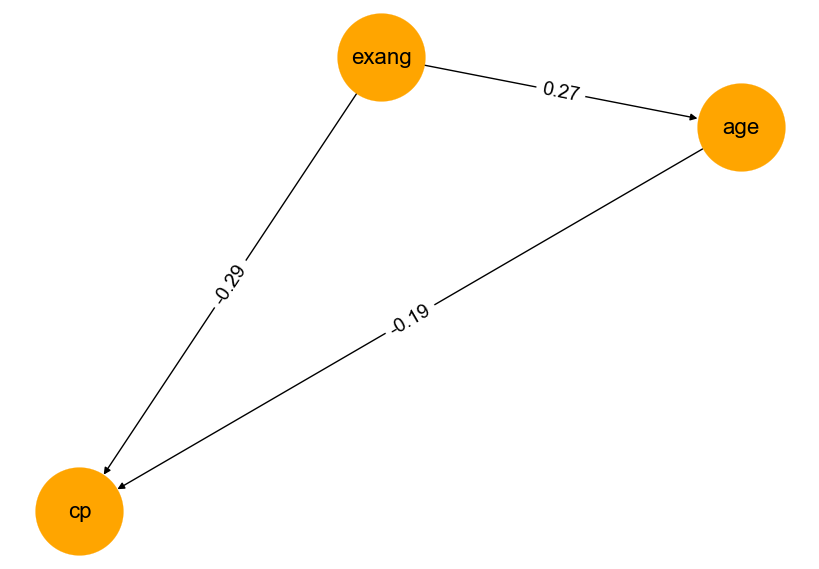

In [7]:
# Classical (Gaussian kernel)
model = DirectLiNGAM(measure='kernel')
model.fit(X)

print(model.causal_order_)

# Make_dot(model.adjacency_matrix_, labels=columns)
plot_dag_nx(model.adjacency_matrix_, columns)

We see that the classical approach fails to identify the correct causal relationship for this particular random data set. As stated above, the correct causal relationship is **`exang`** influencing **`cp`**, while **`age`** is independent of other variables. Here, **`age`** is predicted to influence **`cp`** and be influenced by **`exang`**.

### Summary

In this learning asset, we showed that the qLiNGAM algorithm finds the correct causal relationship for the heart disease problem. We demonstrated that the classical DirectLiNGAM algorithm fails to predict the correct relationship. However, note that this is true for this particular randomly chosen data set, and we could have easily chosen another set of data randomly where the opposite could be true.

There are few directions one may take to extend the methods shared in this notebook, such as those listed below:
- Motivated by AR-LiNGAM, the method could be applied to time series data.
- In this implementation, the IQP kernel was used, but other quantum kernels could be used to explore their potential advantage.
- Continue to explore the potential of qLiNGAM using other data sets.




### References

1. <a name="acyclic"></a>Hideaki Kawaguchi. “Application of Quantum Computing to a Linear Non-Gaussian Acyclic Model for Novel Medical Knowledge Discovery.” arXiv:2110.04485, 2021. https://doi.org/10.48550/arXiv.2110.04485.

2. <a id='DatasetHeartDisease'></a>Andras Janosi et al. “Heart Disease Data Set.” *UCI Machine Learning Repository*, 1988. https://archive.ics.uci.edu/ml/datasets/heart+Disease.

3. <a id='DirectLiNGAM2011'></a>Shimizu et al. “DirectLiNGAM: A Direct Method for Learning a Linear Non-Gaussian Structural Equation Model.” *Journal of Machine Learning Research*, vol. 12 (2011): 1225–1248. https://www.jmlr.org/papers/volume12/shimizu11a/shimizu11a.pdf.

4. <a id='IQP2016'></a>Michael J. Bremner, Ashley Montanaro, and Dan J. Shepherd. “Average-Case Complexity Versus Approximate Simulation of Commuting Quantum Computations.” *Physical Review Letters*, vol. 117 (2016). https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.080501.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>